In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm
from scipy.optimize import fmin_slsqp
import qvalue as qv

In [2]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)




In [3]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [4]:
full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)
for i in full_df['Integrative Cluster'].unique():
    if type(i) == str:
        full_df[f'Intclust {i} or not'] = full_df.apply(lambda row: i if (row['Integrative Cluster'] == i) else 'Not', axis = 1)


In [5]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import qvalue as qv

clusterframes = {}


for i in full_df['Integrative Cluster'].unique():
    if type(i) == str:
        df_cluster = pd.DataFrame(index=pca_per_pathway.columns) 
        pvaluelist = []
        for pathway in df_cluster.index:
            results = ols("Q(pathway) ~ C(Q(f'Intclust {i} or not'))", data=full_df).fit()
            table = sm.stats.anova_lm(results, typ=2)
            pvalue = table['PR(>F)'][0]
            pvaluelist.append(pvalue)
    
        df_cluster['p-values'] = pvaluelist
        qv.qvalues(df_cluster, 'p-values', 'qvalues')
        print(i)
        clusterframes[i] = df_cluster

4ER+
9
7
3
8
10
1
2
5
4ER-
6


In [6]:
significant_pathways = {}
def failures_of_null_anova(cluster, my_xa, my_xb, iterations=10000):
    pvalues = clusterframes[cluster]['p-values'].tolist()
    pvalues = [0.999 if x == 1.0 else x for x in pvalues] ##pathways with p-val 1 gave error as range would be to inf
    pvalues = sorted(pvalues)
    z_scores = norm.ppf(pvalues)
    print(z_scores)
    xa = np.percentile(z_scores, my_xa)
    xb = np.percentile(z_scores, my_xb)
    print(f'Quantiles calculated: {xa}, {xb}')


    trunc_z = z_scores[z_scores>xa]
    trunc_z = trunc_z[trunc_z<xb]

    def func(p, r, xa, xb):
        return truncnorm.nnlf(p, r)

    def constraint(p, r, xa, xb):
        a, b, loc, scale = p
        return np.array([a*scale + loc - xa, b*scale + loc - xb])

    loc_guess = np.median(z_scores)
    scale_guess = np.std(z_scores)
    a_guess = (xa - loc_guess)/scale_guess
    b_guess = (xb - loc_guess)/scale_guess
    p0 = [a_guess, b_guess, loc_guess, scale_guess]

    par = fmin_slsqp(func, p0, f_eqcons=constraint, args=(trunc_z, xa, xb), iter=iterations)
    print(par)

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.hist(z_scores, bins=50, density=True)
    ax.plot(z_scores, truncnorm.pdf(z_scores, par[0], par[1], par[2], par[3]), 'r-', lw=5, alpha=0.6, label='truncnorm pdf')
    ax.plot(z_scores, norm.pdf(z_scores, par[2], par[3]), 'g-', lw=5, alpha=0.6, label='norm pdf')
    ax.plot(z_scores, norm.sf(abs(z_scores-par[2]), par[2], par[3]), 'y-', lw=5, alpha=0.6, label='norm sf')
    ax.legend(loc='best')
    plt.show()

    p_vals = norm.sf(abs(z_scores-par[2]), par[2], par[3])

    plt.figure(figsize=(15, 10))
    plt.hist(p_vals, bins=30, density=True)
    plt.show()
    #print(pvalues[:10])
    print(p_vals[:20])
    sig_pathways = p_vals[p_vals < 0.001].size
    significant_pathways[cluster] = sig_pathways
    print(f'number of pathways with p < 0.001: {p_vals[p_vals < 0.001].size}')
    
    
    ##let's add to clusterframes
    clusterframes[cluster]['adjusted p-value'] = p_vals
    qv.qvalues(clusterframes[cluster], 'adjusted p-value', 'adjusted q-values')
    
    ##and log fold change
    clusterframes[cluster]['log adjusted p-value'] = -np.log10(clusterframes[cluster]['adjusted p-value'])
    clusterframes[cluster]['log adjusted q-value'] = -np.log10(clusterframes[cluster]['adjusted q-values'])

In [7]:
clusterframes['1']

,p-values,qvalues
RMTs methylate histone arginines,2.678034e-44,5.554242e-41
HDMs demethylate histones,1.726380e-40,1.790256e-37
Senescence-Associated Secretory Phenotype (SASP),6.854062e-40,4.169670e-37
Cellular Senescence,8.041793e-40,4.169670e-37
Nucleosome assembly,4.833426e-39,1.670767e-36
...,...,...
5-Phosphoribose 1-diphosphate biosynthesis,9.933281e-01,9.952476e-01
Trafficking and processing of endosomal TLR,9.973872e-01,9.988320e-01
CD28 dependent PI3K/Akt signaling,9.980622e-01,9.989896e-01
Constitutive Signaling by AKT1 E17K in Cancer,9.988501e-01,9.989896e-01


[-13.9119998  -13.27006612 -13.16634135 ...   2.88812157   3.04851915
   3.08715614]
Quantiles calculated: -3.3866202307667503, 3.0791466944178243
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2255.3083333272084
            Iterations: 267
            Function evaluations: 2143
            Gradient evaluations: 267
[-1.33557563  2.6023572  -1.19371316  1.64191905]


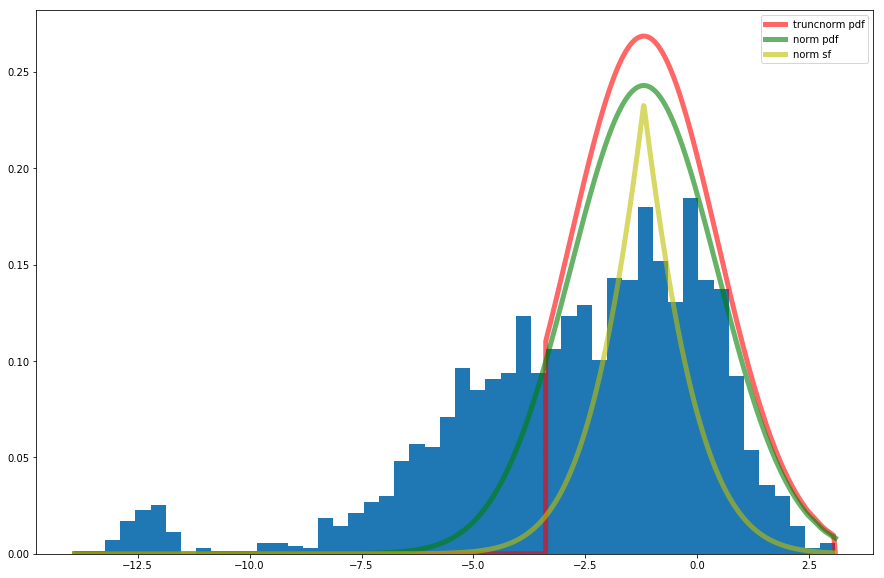

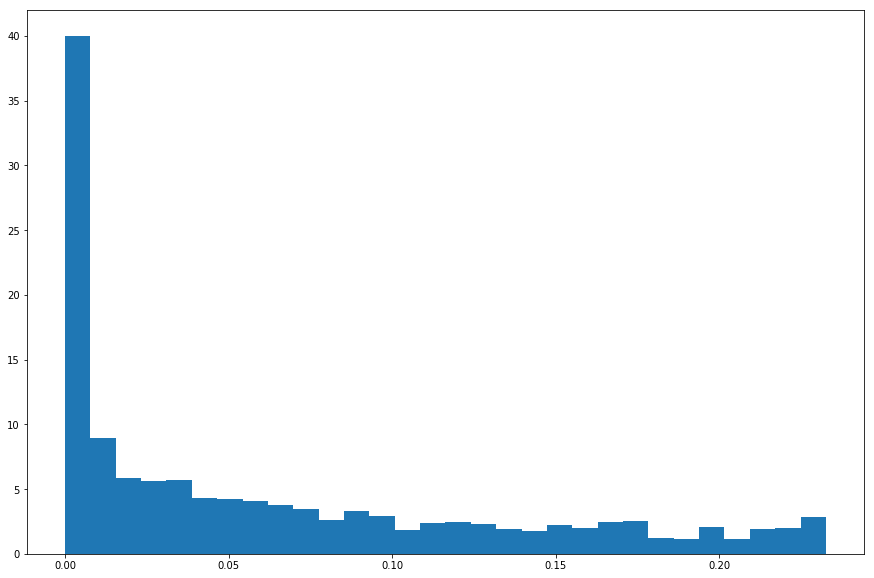

[1.19563950e-17 3.18443967e-16 5.33596086e-16 5.66497534e-16
 1.10879390e-15 1.10879693e-15 1.59475819e-15 2.13636615e-15
 3.03953125e-15 3.33843432e-15 4.18656088e-15 5.52469049e-15
 5.57549412e-15 5.70588250e-15 5.98340555e-15 6.20190340e-15
 8.62009711e-15 8.63109644e-15 8.63111678e-15 1.08129416e-14]
number of pathways with p < 0.001: 392


In [8]:
failures_of_null_anova('1', 35, 99.99)

[-6.84631661 -6.59458776 -6.57521133 ...  2.57862542  2.68407125
  2.84892587]
Quantiles calculated: -1.9487227015155724, 0.3343508380528847
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 929.6904342358471
            Iterations: 74
            Function evaluations: 554
            Gradient evaluations: 74
[-0.92896097  1.03500486 -0.86882295  1.16248129]


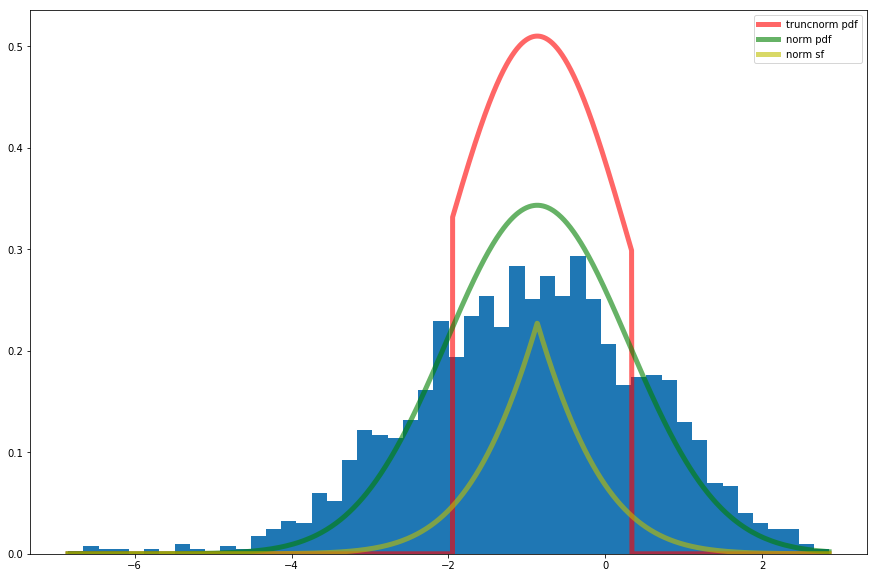

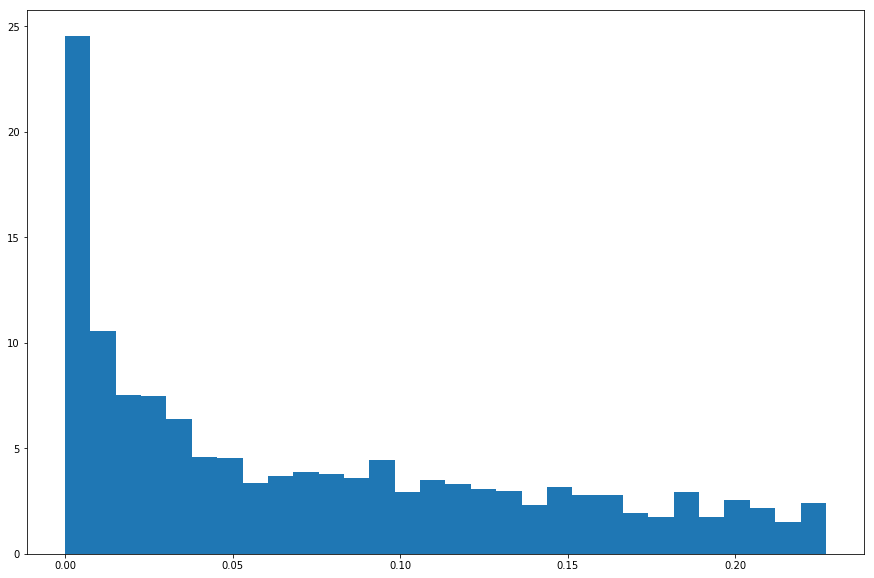

[1.93800847e-09 7.02185650e-09 7.73865112e-09 8.70879259e-09
 1.38928493e-08 2.64788819e-08 4.44490720e-08 6.89175180e-08
 2.19951260e-07 3.06312868e-07 1.25322504e-06 1.72558344e-06
 1.77633711e-06 1.84557478e-06 4.70204883e-06 4.70205390e-06
 9.09560715e-06 1.67784808e-05 1.67785521e-05 1.91237722e-05]
number of pathways with p < 0.001: 117


In [9]:
failures_of_null_anova('2', 25, 80)

[-14.83838977 -14.73374098 -14.67363221 ...   2.56879163   2.59389826
   2.59581911]
Quantiles calculated: -3.781479875312232, 1.7630456657758322
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2008.9868004777372
            Iterations: 129
            Function evaluations: 996
            Gradient evaluations: 129
[-0.8249283   1.80725401 -2.04382058  2.10643675]


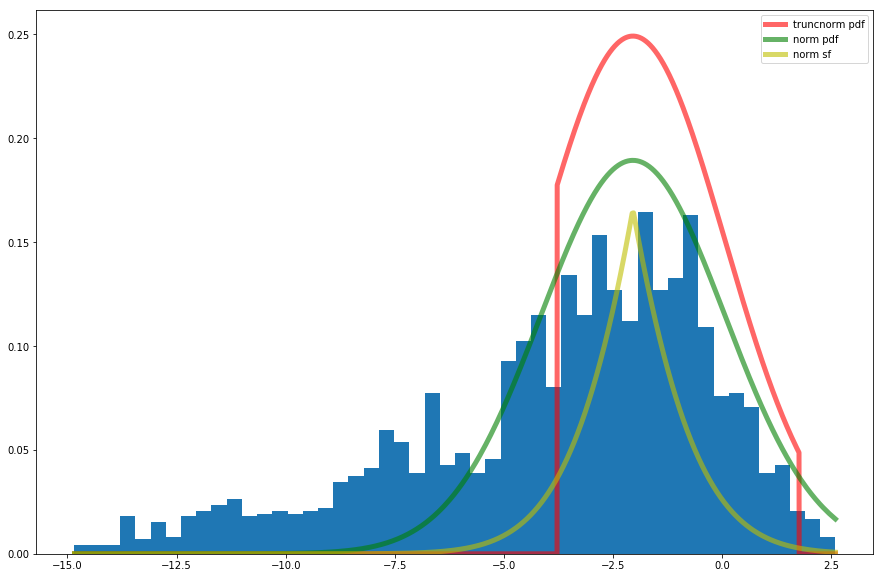

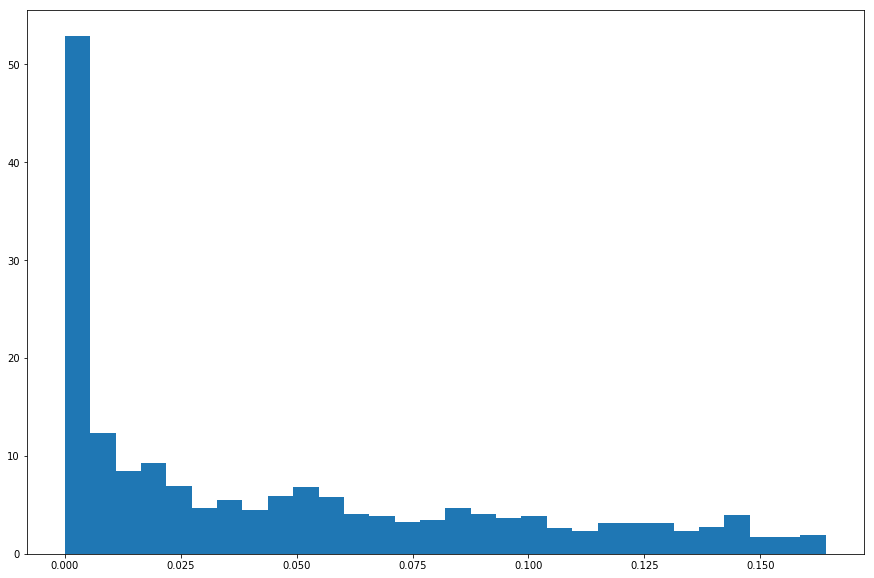

[9.31925543e-13 1.32982042e-12 1.62933021e-12 4.17175644e-12
 4.20458991e-12 5.27046659e-12 1.74495687e-11 2.07905988e-11
 2.07907139e-11 3.73922561e-11 3.84096926e-11 3.84836132e-11
 4.13227682e-11 4.28474221e-11 4.60472966e-11 4.80150295e-11
 5.74654775e-11 5.82897892e-11 5.88788812e-11 7.66721964e-11]
number of pathways with p < 0.001: 437


In [10]:
failures_of_null_anova('3', 40, 99, iterations=100000)

[-13.93086523 -12.3419182  -12.27722993 ...   2.36156958   2.43890359
   2.66449199]
Quantiles calculated: -4.327214793113503, 2.3524708098658613
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2442.6711492945687
            Iterations: 156
            Function evaluations: 1230
            Gradient evaluations: 156
[-1.11199312  1.94249663 -1.89546186  2.18684171]


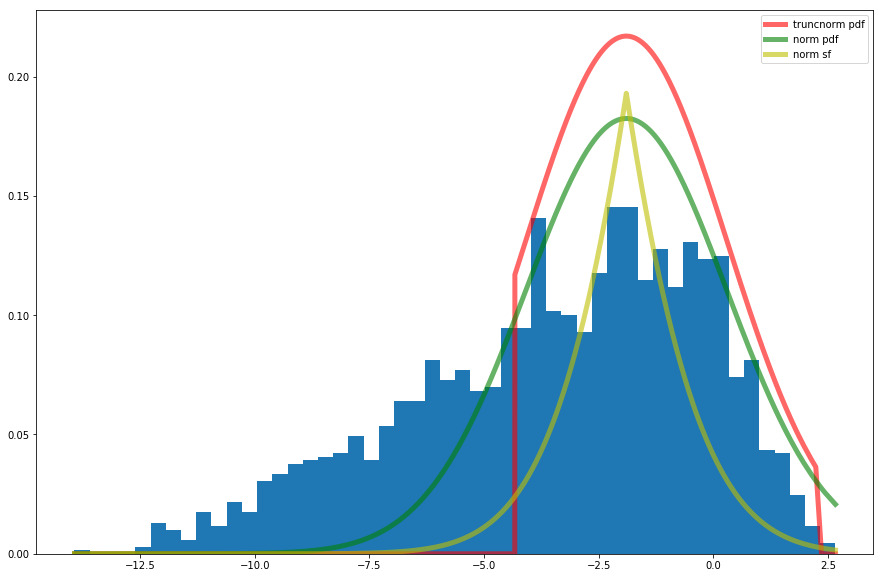

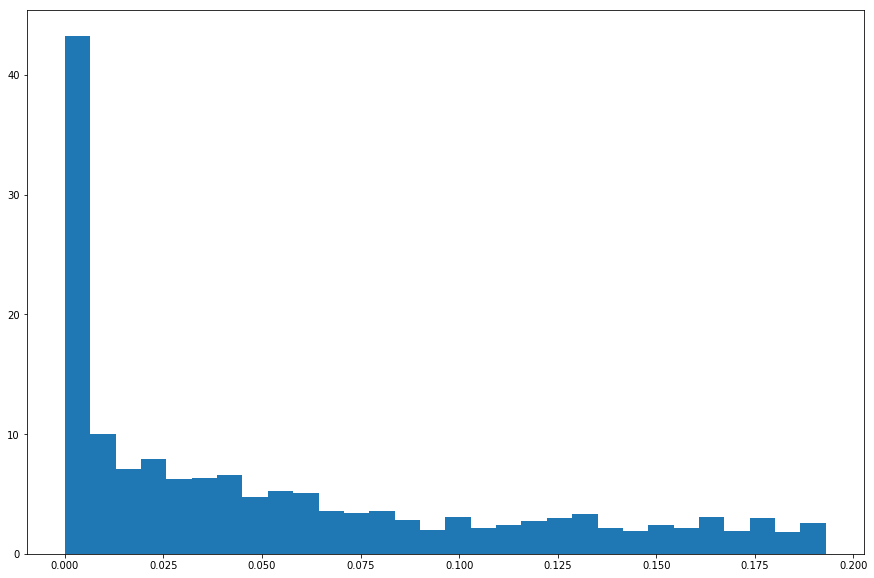

[9.43216843e-11 8.32082311e-09 9.87725830e-09 1.10725944e-08
 1.21073887e-08 1.21556834e-08 1.58110176e-08 1.60914401e-08
 2.02925571e-08 2.16630144e-08 2.20398342e-08 2.32298059e-08
 2.61187023e-08 2.69299166e-08 3.10438413e-08 3.71085160e-08
 4.62321971e-08 4.81420717e-08 4.94393472e-08 6.15682940e-08]
number of pathways with p < 0.001: 342


In [11]:
failures_of_null_anova('4ER-', 35, 99.9)

[-17.96216636 -16.73041369 -16.4718797  ...   2.74006575   2.74036923
   3.08908026]
Quantiles calculated: -4.724111263333868, 1.369161947331994
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1981.6688519263168
            Iterations: 321
            Function evaluations: 2543
            Gradient evaluations: 321
[-1.11152678  1.53667634 -2.16658979  2.30090856]


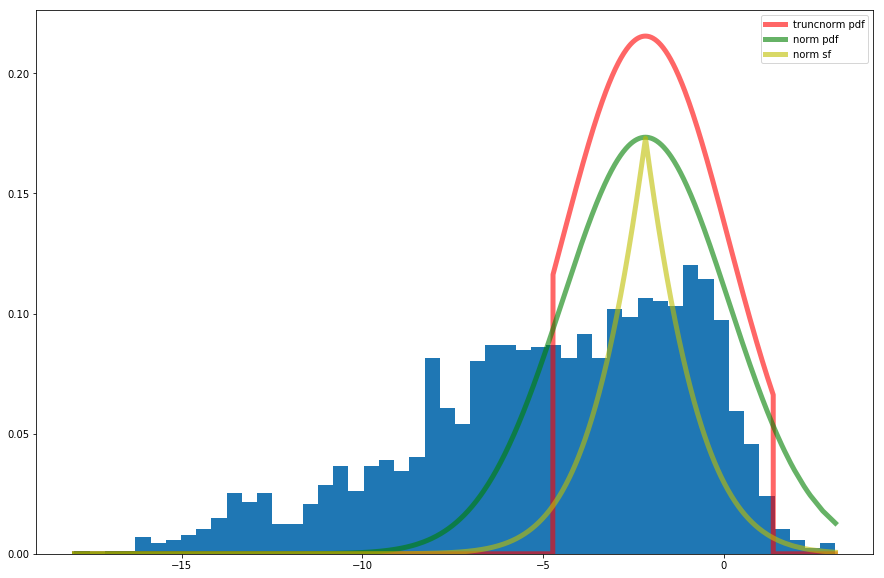

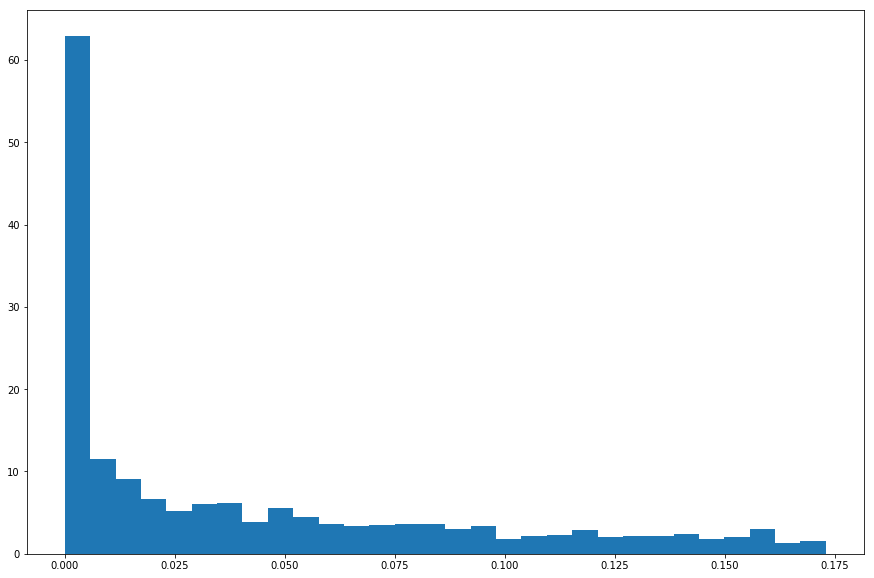

[2.93864537e-15 1.78126812e-13 4.06756839e-13 7.70028222e-13
 8.42463145e-13 8.44154702e-13 1.21556211e-12 1.59597667e-12
 1.63254970e-12 2.77812278e-12 3.81084960e-12 4.71653710e-12
 5.61361109e-12 1.09207940e-11 1.86888832e-11 1.89764006e-11
 2.42566241e-11 2.65234203e-11 4.33565263e-11 5.81574282e-11]
number of pathways with p < 0.001: 525


In [12]:
failures_of_null_anova('4ER+', 45, 99)

[-19.17431748 -18.97033885 -18.24982862 ...   2.78656516   2.90959138
   3.08069778]
Quantiles calculated: -4.640139573741501, 1.7418364317210873
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2918.014266703949
            Iterations: 92
            Function evaluations: 689
            Gradient evaluations: 92
[-1.57737078  1.77409807 -1.63645882  1.90423253]


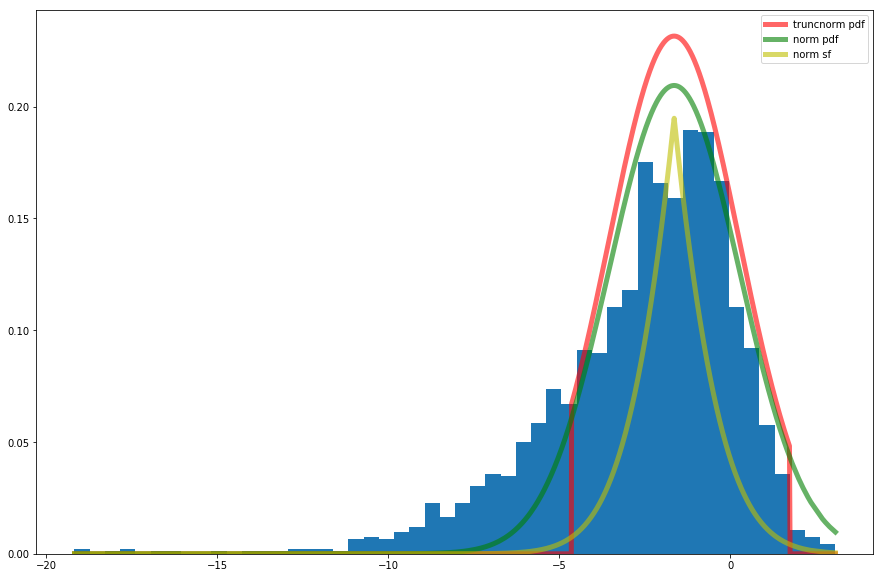

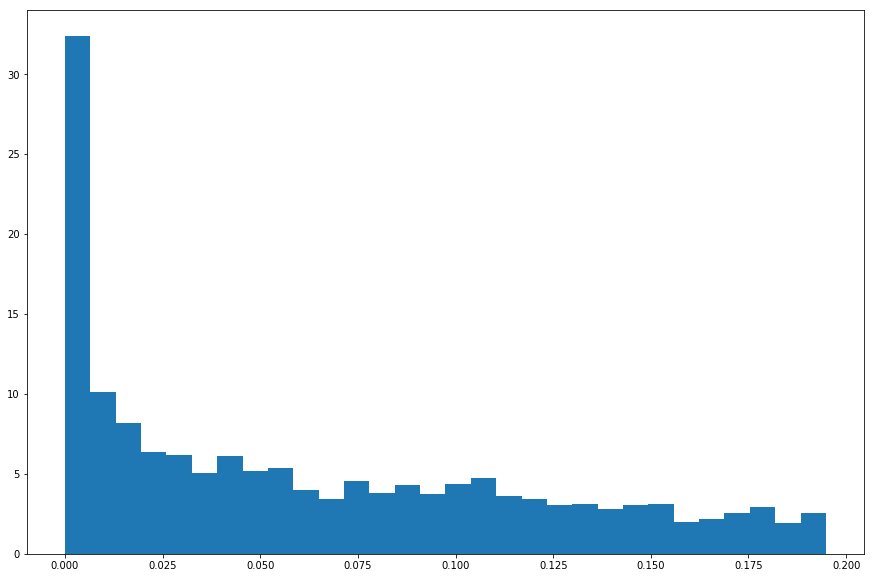

[3.77509791e-24 1.11539237e-23 4.67586322e-22 2.74531492e-20
 3.08797404e-20 4.50525024e-19 1.39911079e-17 2.79485360e-15
 3.32721925e-14 1.00459331e-12 4.80001067e-12 6.48624487e-12
 7.90432371e-12 3.68490746e-11 4.12533461e-11 2.06227963e-10
 3.92089674e-10 5.91237046e-10 2.40061069e-09 5.50353183e-09]
number of pathways with p < 0.001: 249


In [13]:
failures_of_null_anova('5', 20, 99)

[-33.62247858 -16.41150422  -9.77234282 ...   3.21698071   3.21743531
   3.21760124]
Quantiles calculated: -30.05464359855927, 3.2175668444235708
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4104.914537968234
            Iterations: 99
            Function evaluations: 775
            Gradient evaluations: 99
[-15.94259266   2.5634612   -1.39130446   1.79790952]


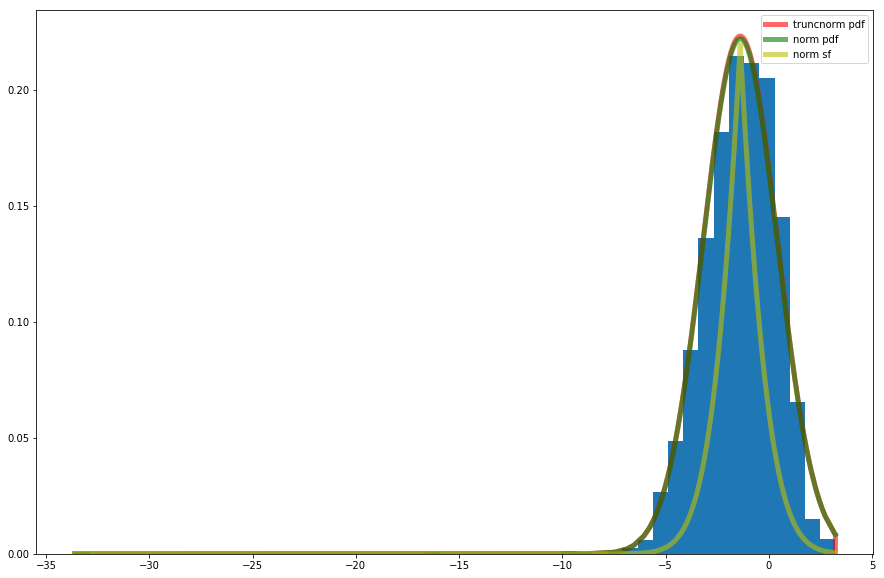

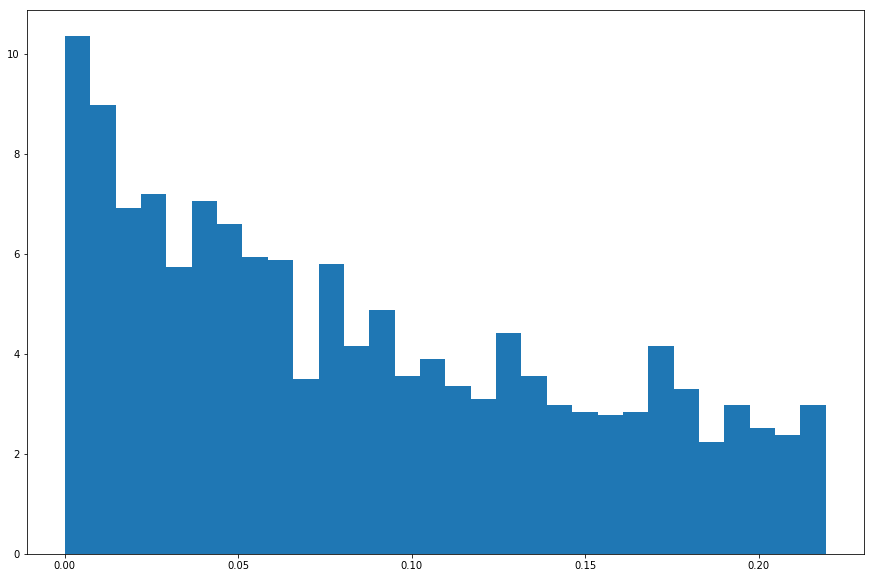

[2.43501694e-78 3.48548531e-20 2.73380646e-08 6.40439056e-08
 5.18686561e-07 1.45577760e-05 1.82621021e-05 5.79522400e-05
 6.01613765e-05 6.51068408e-05 1.36332787e-04 3.60824985e-04
 3.70494255e-04 5.66241574e-04 6.00956812e-04 6.16687205e-04
 6.39966463e-04 6.72146852e-04 7.16573436e-04 8.79077167e-04]
number of pathways with p < 0.001: 29


In [14]:
failures_of_null_anova('6', 0.01, 99.99)

[-12.92433509 -12.73774146 -11.67546537 ...   2.8660079    2.93598415
   3.2522174 ]
Quantiles calculated: -12.885654229763801, 3.18666225035813
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5123.44331796708
            Iterations: 6
            Function evaluations: 40
            Gradient evaluations: 6
[-3.02276703  2.29989339 -3.75810061  3.01960208]


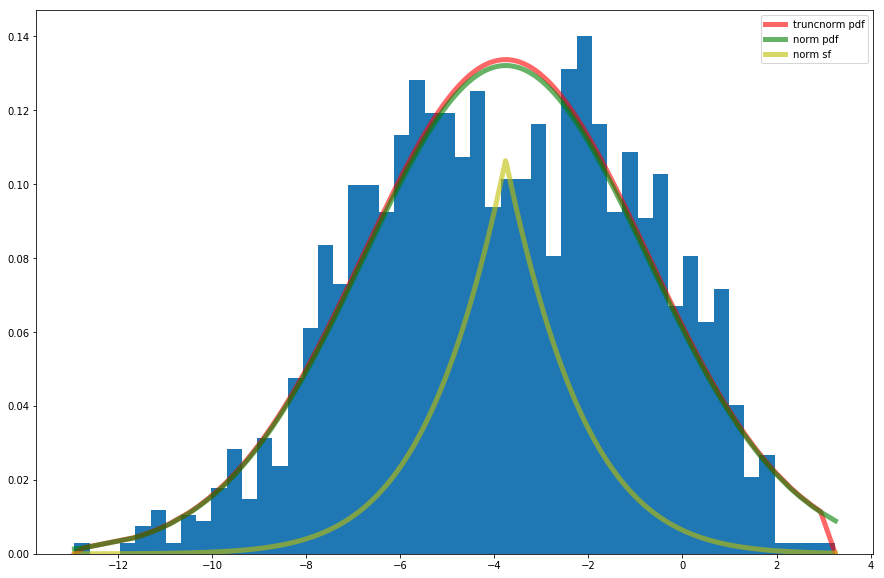

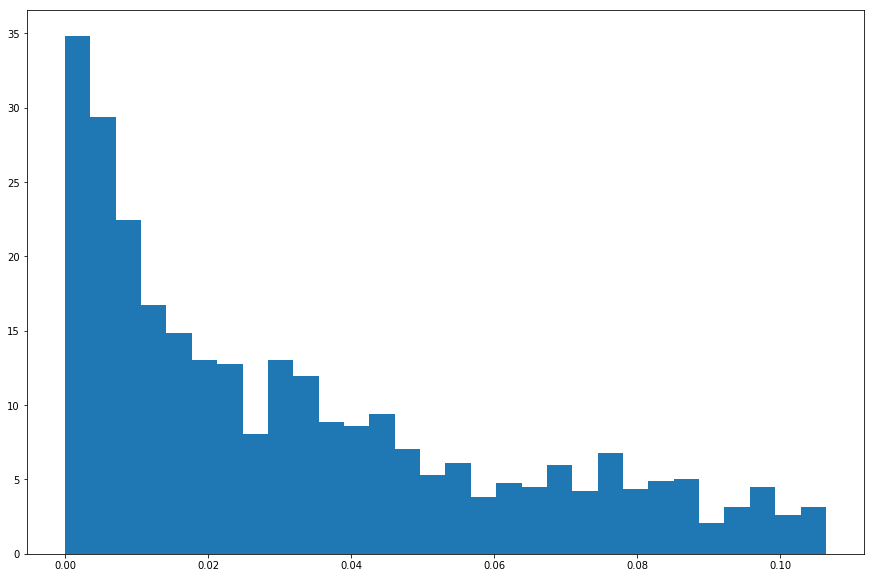

[9.33857456e-06 1.23047756e-05 5.51912013e-05 5.59867947e-05
 5.92993715e-05 6.02634139e-05 6.61787147e-05 6.87576317e-05
 8.83126888e-05 9.25772009e-05 9.26070491e-05 9.93544090e-05
 1.04573300e-04 1.04683851e-04 1.18844420e-04 1.27771987e-04
 1.30388519e-04 1.52425589e-04 1.56573794e-04 2.39056709e-04]
number of pathways with p < 0.001: 74


In [15]:
failures_of_null_anova('7', 0.01, 99.99)

[-24.44703769 -19.95758085 -17.62577911 ...   2.65103978   3.34448305
   3.34621721]
Quantiles calculated: -8.025937763642421, 1.3578219383379848
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3271.73259077729
            Iterations: 52
            Function evaluations: 370
            Gradient evaluations: 52
[-1.14653697  1.10381536 -3.24498535  4.16990689]


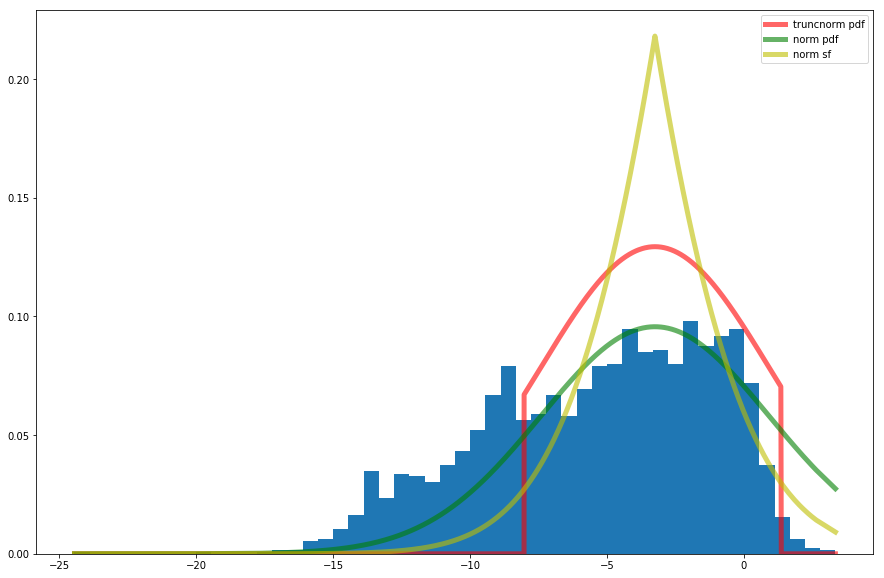

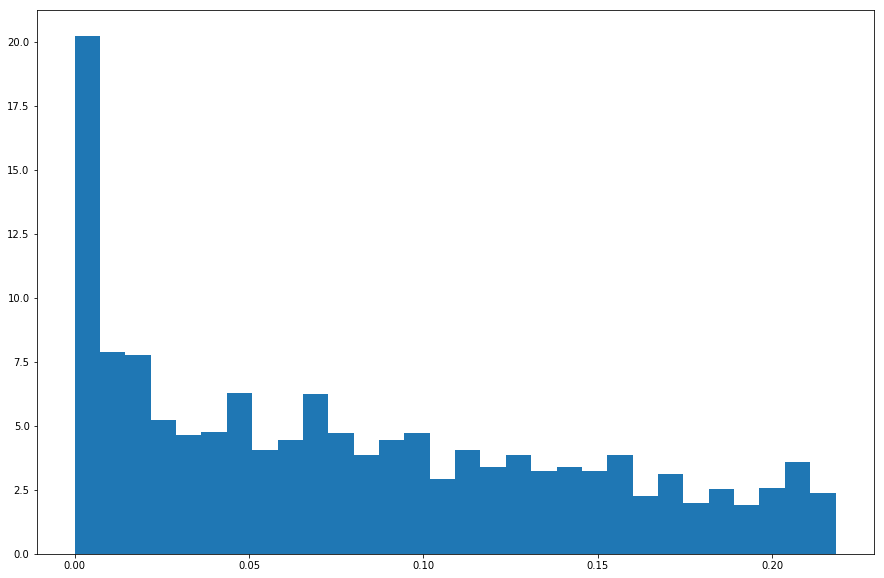

[2.27659308e-09 8.50277430e-07 1.18466490e-05 2.37600948e-05
 3.13114868e-05 4.67438756e-05 4.72362439e-05 6.06730568e-05
 6.79367234e-05 8.06894241e-05 8.16254871e-05 8.27261748e-05
 8.77772756e-05 9.97992086e-05 1.15494298e-04 1.18281099e-04
 1.30017767e-04 1.45037989e-04 1.49633647e-04 1.55941418e-04]
number of pathways with p < 0.001: 114


In [16]:
failures_of_null_anova('8', 28, 99)

[-17.40250118 -17.1360966  -17.13605926 ...   2.93432457   3.00675783
   3.22513698]
Quantiles calculated: -3.747773078817006, 2.931699477980507
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2632.848303260692
            Iterations: 52
            Function evaluations: 383
            Gradient evaluations: 52
[-1.43025026  2.66524524 -1.41513289  1.63093148]


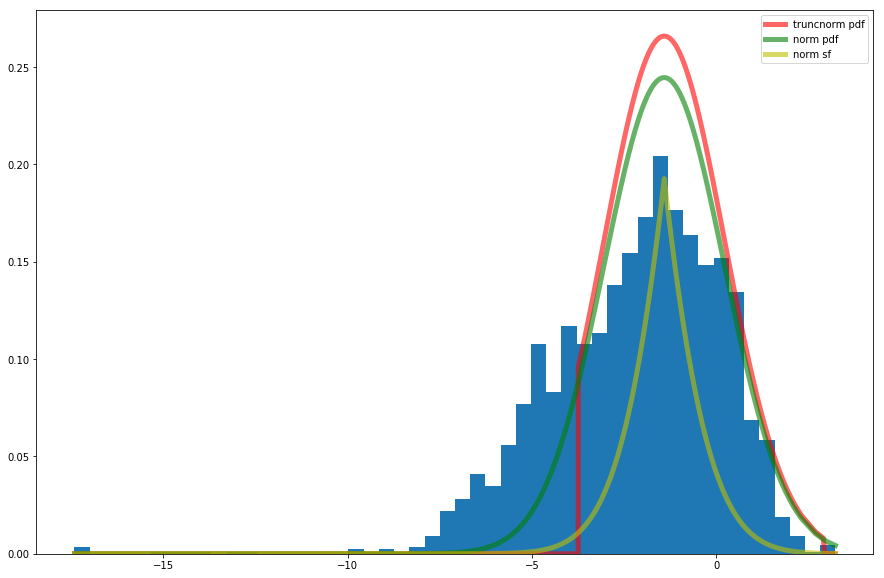

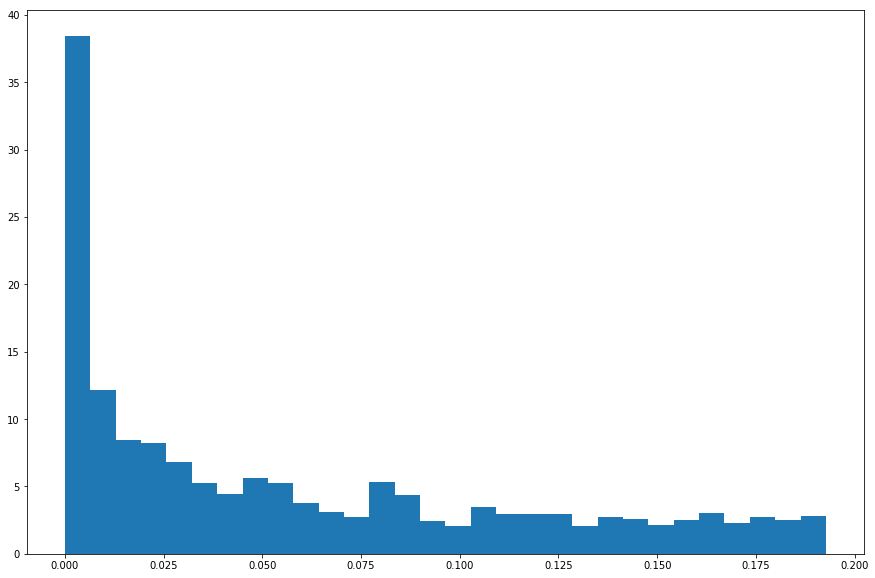

[7.00990463e-27 4.01284019e-26 4.01381423e-26 1.24176785e-20
 7.51898593e-20 1.52328306e-18 3.75842148e-18 7.26610061e-16
 1.55150544e-15 7.33575342e-10 9.94430024e-10 9.62437273e-09
 1.24393199e-08 1.51840069e-08 8.58110025e-08 2.68529683e-07
 5.01501410e-07 6.03921323e-07 6.56866703e-07 6.91077162e-07]
number of pathways with p < 0.001: 254


In [17]:
failures_of_null_anova('9', 25, 99.9)

[-34.66291375 -34.66291179 -33.31015597 ...   2.28558475   2.6496367
   2.70303907]
Quantiles calculated: -11.727118245400064, 2.7019320354627903
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3529.824314514408
            Iterations: 129
            Function evaluations: 980
            Gradient evaluations: 129
[-1.37690872  1.60442589 -5.06316141  4.83979564]


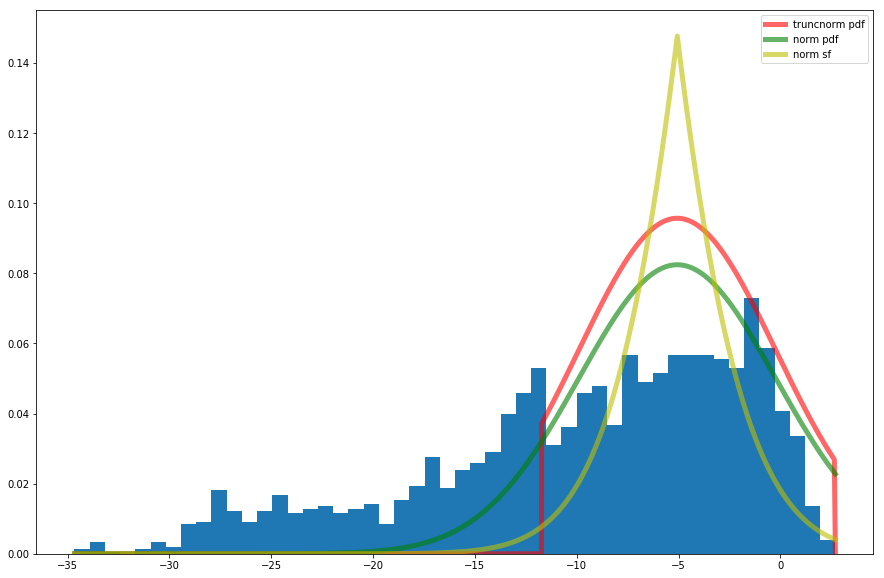

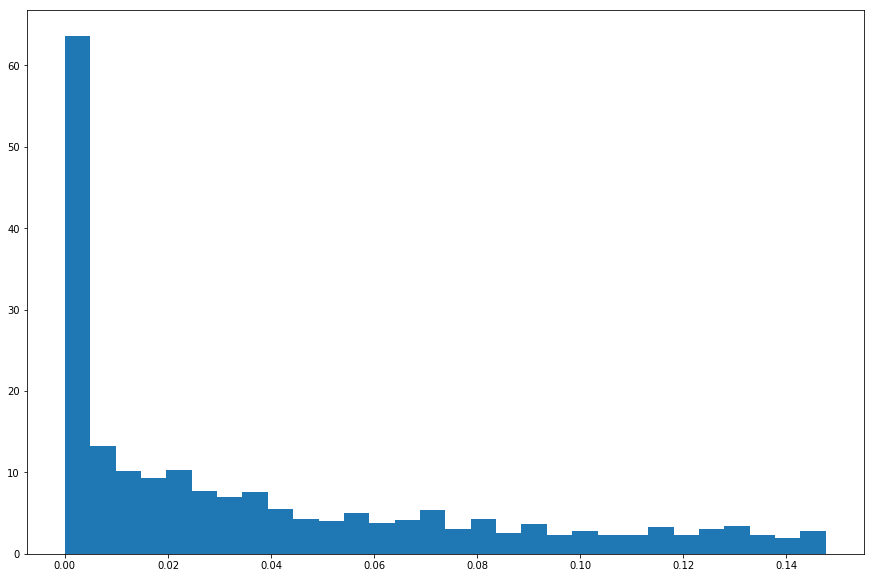

[3.97363915e-13 3.97365084e-13 2.93943854e-12 2.93945019e-12
 2.93945371e-12 2.93945764e-12 2.93946328e-12 4.10173070e-12
 3.81853843e-11 4.53653231e-11 8.93500809e-11 1.31716238e-10
 1.69305030e-10 1.84915980e-10 2.19894354e-10 4.01440782e-10
 4.09465007e-10 5.46080889e-10 6.09310862e-10 7.19703570e-10]
number of pathways with p < 0.001: 458


In [18]:
failures_of_null_anova('10', 35, 99.999)

In [19]:
gsea_df = pd.read_csv('../exp/GSEA_qvalues.csv', index_col = 0)
gsea_df_counts = {}

for column in gsea_df.columns:
    columnshape = gsea_df[gsea_df[column] >= 3].shape[0]
    gsea_df_counts[column] = columnshape

adjusted_q_counts = {}
for cluster in clusterframes:
    columnshape = clusterframes[cluster][clusterframes[cluster]['adjusted q-values'] <= 0.001].shape[0]
    adjusted_q_counts[cluster] = columnshape
    
wall_df = pd.read_csv('../exp/pathway_qvalues.csv', index_col = 0)
wal_df = wall_df.loc[:, wall_df.columns.str.endswith('q-values')]
new_name = {}
for i in wal_df.columns:
    new_i = i.strip('Cluster q-values')
    new_name[i] = new_i
    
wal_df = wal_df.rename(columns =new_name)

wall_df_counts = {}
for column in wal_df.columns:
    columnshape = wal_df[wal_df[column] >= 3].shape[0]
    #print(columnshape)
    wall_df_counts[column] = columnshape

wall_df_counts['4ER-'] = wall_df_counts.pop('4ER')
print(wall_df_counts)
print(adjusted_q_counts)

{'1': 828, '10': 1615, '2': 78, '3': 1048, '4ER+': 1303, '5': 839, '6': 290, '7': 1126, '8': 1354, '9': 723, '4ER-': 1029}
{'4ER+': 366, '9': 87, '7': 0, '3': 312, '8': 2, '10': 343, '1': 235, '2': 16, '5': 135, '4ER-': 207, '6': 5}


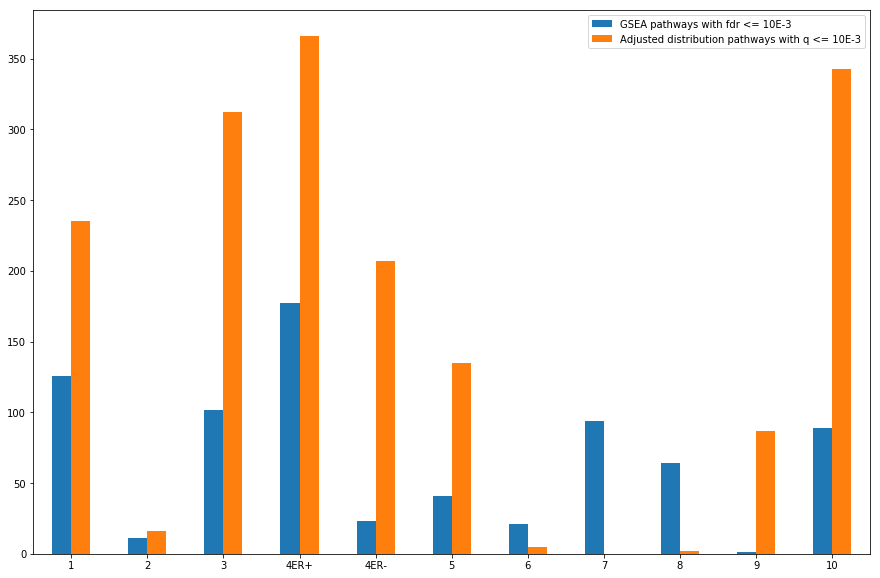

In [20]:
full_df = pd.DataFrame({'GSEA pathways with fdr <= 10E-3': gsea_df_counts, 
                        #'Mann whitney pathways with q-value <= 10E-3': significant_pathways,
                        #'Wall pathways with q <= 10E-3': wall_df_counts,
                        'Adjusted distribution pathways with q <= 10E-3': adjusted_q_counts})
ax = full_df.plot.bar(rot=0, figsize=(15, 10))
plt.show()